This script quantifies non-additive effects as in PMID 25897392.

In [1]:
import pandas, numpy

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':30, 'ytick.labelsize':30, 'figure.figsize':(16, 9), 'axes.labelsize':40})

# 0. user-defined variables

In [3]:
expression_file = '/home/adrian/projects/nautholsvik/results/tpm/DESeq2_TPM_values.tsv'
significance_dir = '/home/adrian/projects/nautholsvik/results/DEGs_DESeq2/'
annotation_file = '/home/adrian/projects/nautholsvik/results/annotation/annotation.csv'

expression_figures_dir = '/home/adrian/projects/nautholsvik/results/non-additive/'

In [4]:
genotypes = ['siCTRL', 'siMITF']
treatments = ['wo_IFN', 'with_IFN']

# 1. read annotation

In [5]:
raw = {}
with open(annotation_file, 'r') as f:
    header = f.readline()
    for line in f:
        v = line.split(',')
        v = [element.replace('"', '') for element in v]
        v[-1] = v[-1].replace('\n', '')
        
        gene_name = ''
        ensembl = v[2]
        gene_name = v[3]
        description = v[4].split('[Source')[0]
        if gene_name == '':
            gene_name = ensembl
            
        #if ensembl == 'ENSG00000096150':
        #    print(v)
            
        raw[ensembl] = [gene_name, description]
        
# create a dataframe
df = pandas.DataFrame.from_dict(raw)
annotation = df.transpose()
annotation.columns = ['gene_name', 'description']
print(annotation.shape)

(68324, 2)


In [6]:
# print(annotation.loc['ENSG00000096150', ])
# print(annotation.loc['ENSG00000210049', ])

In [7]:
# annotation = pandas.read_csv(annotation_file, sep=',', index_col='ens_gene')
# annotation.drop(columns=['Unnamed: 0', 'target_id'], inplace=True)
# annotation.drop_duplicates(inplace=True)
# print(annotation.shape)

# 2. read and manipulate expression data

In [8]:
expression_with_replicates = pandas.read_csv(expression_file, sep='\t', index_col=0)

In [9]:
plotting_df = pandas.DataFrame()
replicate_labels = expression_with_replicates.columns

for genotype in genotypes:
    for treatment in treatments:
        new_label = genotype + '_' + treatment + '_tpm'
        sub = [label for label in replicate_labels if genotype in label and treatment in label]
        df = expression_with_replicates[sub]
        plotting_df[new_label] = df.median(axis=1)

In [10]:
plotting_df['average_expression_tpm'] = plotting_df.mean(axis=1)
plotting_df['max_expression_tpm'] = plotting_df.max(axis=1)

plotting_df['geneID'] = annotation['gene_name']
plotting_df['description'] = annotation['description']

print(plotting_df.shape)
plotting_df.head()

(40173, 8)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD,tenomodulin
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112


# 3. add fold-changes of each independent effect

In [11]:
plotting_df['A1A0_log2fc'] = numpy.log2(plotting_df['siCTRL_with_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)
plotting_df['B0A0_log2fc'] = numpy.log2(plotting_df['siMITF_wo_IFN_tpm']+1) - numpy.log2(plotting_df['siCTRL_wo_IFN_tpm']+1)

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TNMD,tenomodulin,0.000000,0.000000
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281


# 4. read fold changes and P values from DESeq2

In [12]:
# read signifcances
df = pandas.read_csv(significance_dir+'A0_A1_transition.tsv', sep='\t', index_col=0)
plotting_df['P_A1A0'] = df['padj']

df = pandas.read_csv(significance_dir+'A0_B0_transition.tsv', sep='\t', index_col=0)
plotting_df['P_B0A0'] = df['padj']

df = pandas.read_csv(significance_dir+'interaction.tsv', sep='\t', index_col=0)
plotting_df['P_interaction'] = df['padj']

# 5. remove element whose top expression is below 2 TPM

In [13]:
plotting_df.fillna(1, inplace=True)

In [14]:
# remove low-expression genes: less than two tpm
print(plotting_df.shape)
plotting_df.drop(plotting_df[plotting_df['max_expression_tpm'] < 2].index, inplace=True)
print(plotting_df.shape)

(40173, 13)
(12742, 13)


In [15]:
plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16


In [16]:
plotting_df.loc['ENSG00000284610', ]

siCTRL_wo_IFN_tpm                    5.648556
siCTRL_with_IFN_tpm                  3.222984
siMITF_wo_IFN_tpm                    1.713617
siMITF_with_IFN_tpm                  2.304635
average_expression_tpm               3.222448
max_expression_tpm                   5.648556
geneID                        ENSG00000284610
description               RNA binding protein
A1A0_log2fc                         -0.654778
B0A0_log2fc                         -1.292824
P_A1A0                               0.054976
P_B0A0                                    0.0
P_interaction                        0.030959
Name: ENSG00000284610, dtype: object

In [17]:
# these numbers is to see the effect of removing low-expressed genes, it is not represtantive of the final set of genes, specially for the interaction
# originally, at the significance level we had A1A0: 4,414; B0A0: 9,116 and interaction: 700
print(sum(plotting_df['P_A1A0'] < 0.1))
print(sum(plotting_df['P_B0A0'] < 0.1))
print(sum(plotting_df['P_interaction'] < 0.1))

3929
7633
631


In [18]:
# check if MITF is A0 to B0 transition
print('ENSG00000187098' in plotting_df[plotting_df['P_B0A0'] < 0.1].index)

# check if PD-L1 is a gene with significant interaction
print('ENSG00000120217' in plotting_df[plotting_df['P_interaction'] < 0.1].index)

True
True


# 6. add a column of the expected expression given both factors

In [19]:
# add expected expression
deltaA = plotting_df['siCTRL_with_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
deltaB = plotting_df['siMITF_wo_IFN_tpm'] - plotting_df['siCTRL_wo_IFN_tpm']
expected = plotting_df['siCTRL_wo_IFN_tpm'] + deltaA + deltaB
plotting_df['expected'] = expected 
plotting_df.loc[plotting_df['expected'] < 0,'expected'] = 0 # avoid predicting negative expression

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00,21.941919
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00,154.617808
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00,12.477084
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00,23.692946
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16,2.244778


# 7. determine non-linear effects at fold-change level

In [20]:
# add log2FC observed / expected expression
non_additive = numpy.log2(plotting_df['siMITF_with_IFN_tpm']+1) - numpy.log2(plotting_df['expected']+1)
plotting_df['log2FC_observed_expected'] = non_additive

plotting_df.head()

,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected
ENSG00000000003,24.864996,22.810767,23.996147,23.638828,23.827684,24.864996,TSPAN6,tetraspanin 6,-0.119387,-0.049295,1.000000e+00,0.047093,1.000000e+00,21.941919,0.102948
ENSG00000000419,148.830008,143.782572,159.665244,156.673309,152.237783,159.665244,DPM1,dolichyl-phosphate mannosyltransferase subunit 1,-0.049439,0.100731,1.000000e+00,1.000000,1.000000e+00,154.617808,0.018931
ENSG00000000457,6.434201,9.625513,9.285772,11.832608,9.294523,11.832608,SCYL3,SCY1 like pseudokinase 3,0.515283,0.468401,4.729447e-06,0.000422,1.000000e+00,12.477084,-0.070694
ENSG00000000460,42.553495,32.939327,33.307114,22.274693,32.768657,42.553495,C1orf112,chromosome 1 open reading frame 112,-0.359831,-0.344281,5.019661e-03,0.000003,1.000000e+00,23.692946,-0.085337
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,4.909581e-46,0.003251,3.700648e-16,2.244778,1.684238


# 8. learn type of non-additive effect

In [21]:
plotting_df['interaction_type'] = 'not avail.'

for ensembl, row in plotting_df.iterrows():
        
    CT = plotting_df.loc[ensembl, 'siCTRL_wo_IFN_tpm']
    A = plotting_df.loc[ensembl, 'siCTRL_with_IFN_tpm']
    B = plotting_df.loc[ensembl, 'siMITF_wo_IFN_tpm']
    obs = plotting_df.loc[ensembl, 'siMITF_with_IFN_tpm']
    AB = plotting_df.loc[ensembl, 'expected']
    
    ### case (i) in Figure 2 from PMID 25897392
    if A < CT and B < CT:
        if obs > CT:
            relationship = '+S'
        elif CT > obs > AB:
            relationship = '-A'
        elif obs < AB:
            relationship = '-S'
        elif obs == AB:
            relationship = 'additive'
        else:
            print(CT, A, B, AB, obs)            
            raise ValueError('case (i) not handled')
            
    ### case (ii) in Figure 2 from PMID 25897392
    elif (A > CT and B < CT) or (A < CT and B > CT):
        if obs > numpy.max([A, B]):
            relationship = '+S'
        elif numpy.max([A, B]) > obs > AB:
            relationship = '-A'
        elif AB > obs >= numpy.min([A, B]): # the equal here is for full +A
            relationship = '+A'
        elif obs < numpy.min([A, B]):
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (ii) not handled')
    
    ### case (iii) in Figure 2 from PMID 25897392
    elif A >= CT and B >= CT:
        if obs > AB:
            relationship = '+S'
        elif AB > obs >= CT: # the equal here is bc it goes back to zero, full +A
            relationship = '+A'
        elif obs < CT:
            relationship = '-S'
        else:
            print(CT, A, B, AB, obs)
            raise ValueError('case (iii) not handled')
    else:
        print(CT, A, B, AB, obs)
        raise ValueError('unknown case not handled')
        
    # assignment
    plotting_df.loc[ensembl, 'interaction_type'] = relationship

# 8. exploratory subsetting

In [22]:
# expecting 222 passing log2 filter

non_additive_df = plotting_df[numpy.abs(plotting_df['log2FC_observed_expected']) > 1]
print(non_additive_df.shape)
non_additive_df.head()

(222, 16)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,4.909581e-46,3.251351e-03,3.700648e-16,2.244778,1.684238,+S
ENSG00000004487,121.353473,217.621951,91.539242,88.257174,129.692960,217.621951,KDM1A,lysine demethylase 1A,0.837383,-0.402918,1.333847e-50,1.439674e-22,3.064888e-27,187.807721,-1.080878,-S
ENSG00000004777,0.632326,0.740612,2.840188,0.700037,1.228291,2.840188,ARHGAP33,Rho GTPase activating protein 33,0.092665,1.234247,1.000000e+00,2.382447e-18,1.219202e-02,2.948473,-1.215729,+A
ENSG00000005981,73.125427,54.287924,23.883388,23.477727,43.693616,73.125427,ASB4,ankyrin repeat and SOCS box containing 4,-0.423004,-1.574786,3.767529e-12,1.156243e-192,1.564934e-04,5.045885,2.017444,-A
ENSG00000006451,83.490302,198.225113,64.786113,82.954481,107.364002,198.225113,RALA,RAS like proto-oncogene A,1.237542,-0.361003,4.035045e-80,2.210655e-19,5.048511e-09,179.520924,-1.104487,+A


In [23]:
# expecting 66 passing both significance and log2 filters

non_additive_and_significant_df = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]

# check if PD-L1 is a gene with significant interaction (ENSG00000120217)
print('ENSG00000120217' in non_additive_and_significant_df.index)

print(non_additive_and_significant_df.shape)
non_additive_and_significant_df.head()

False
(66, 16)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000000971,0.362546,2.480156,0.127168,9.427765,3.099409,9.427765,CFH,complement factor H,1.352847,-0.273603,4.909581e-46,3.251351e-03,3.700648e-16,2.244778,1.684238,+S
ENSG00000004487,121.353473,217.621951,91.539242,88.257174,129.692960,217.621951,KDM1A,lysine demethylase 1A,0.837383,-0.402918,1.333847e-50,1.439674e-22,3.064888e-27,187.807721,-1.080878,-S
ENSG00000004777,0.632326,0.740612,2.840188,0.700037,1.228291,2.840188,ARHGAP33,Rho GTPase activating protein 33,0.092665,1.234247,1.000000e+00,2.382447e-18,1.219202e-02,2.948473,-1.215729,+A
ENSG00000005981,73.125427,54.287924,23.883388,23.477727,43.693616,73.125427,ASB4,ankyrin repeat and SOCS box containing 4,-0.423004,-1.574786,3.767529e-12,1.156243e-192,1.564934e-04,5.045885,2.017444,-A
ENSG00000006451,83.490302,198.225113,64.786113,82.954481,107.364002,198.225113,RALA,RAS like proto-oncogene A,1.237542,-0.361003,4.035045e-80,2.210655e-19,5.048511e-09,179.520924,-1.104487,+A


In [24]:
# expecting 86 cases of more than 150% change

# border-line cases, 13 cases for 0.9 up to 1.
# if we we a threshold of 150%, then we have 86, including PD-L1
border_line = plotting_df[(plotting_df['P_interaction'] < 0.05) & (numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (numpy.abs(plotting_df['log2FC_observed_expected']) < 1)]
print('CD274' in border_line['geneID'].values)
print(border_line.shape)
border_line

True
(86, 16)


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000001617,1.884419,10.023886,0.858288,17.860497,7.656773,17.860497,SEMA3F,semaphorin 3F,1.934280,-0.634306,2.693530e-60,1.073405e-08,6.015352e-14,8.997756,0.915691,+S
ENSG00000004799,297.741446,147.271278,268.412358,213.451657,231.719185,297.741446,PDK4,pyruvate dehydrogenase kinase 4,-1.010658,-0.149081,3.572457e-46,2.640394e-09,9.601362e-09,117.942191,0.850392,-A
ENSG00000004846,9.545795,6.299187,0.393679,0.575647,4.203577,9.545795,ABCB5,ATP binding cassette subfamily B member 5,-0.530860,-2.919698,2.351728e-06,1.886591e-123,3.265272e-04,0.000000,0.655944,-A
ENSG00000026950,6.429726,12.034970,8.110338,24.814643,12.847419,24.814643,BTN3A1,butyrophilin subfamily 3 member A1,0.811006,0.294196,4.195168e-06,1.000000e+00,4.696302e-03,13.715582,0.810845,+S
ENSG00000065371,15.112306,14.020806,5.317740,8.408569,10.714855,15.112306,ROPN1,rhophilin associated tail protein 1,-0.101201,-1.350682,1.000000e+00,1.683780e-26,7.807860e-03,4.226240,0.848202,-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000206452,13.809269,111.279021,14.478451,189.603890,82.292658,189.603890,HLA-C,major histocompatibility complex,2.922516,0.063761,1.214954e-282,1.000000e+00,3.263938e-08,111.948203,0.754916,+S
ENSG00000215817,7.862969,6.552685,2.336237,2.513366,4.816314,7.862969,ZC3H11B,zinc finger CCCH-type containing 11B,-0.230800,-1.409568,2.049406e-04,1.567361e-116,1.848965e-04,1.025953,0.794253,-A
ENSG00000227051,1.869758,3.265980,1.420025,1.179776,1.933885,3.265980,C14orf132,chromosome 14 open reading frame 132,0.571948,-0.245908,7.429390e-14,1.839918e-04,2.370069e-02,2.816246,-0.807974,-S
ENSG00000273686,690.196169,2806.907857,828.823798,4747.825321,2268.438286,4747.825321,B2M,beta-2-microglobulin,2.022328,0.263710,5.545732e-128,1.000000e+00,5.572132e-05,2945.535486,0.688551,+S


In [25]:
border_line.loc['ENSG00000120217', ] # CD274

siCTRL_wo_IFN_tpm                   1.80042
siCTRL_with_IFN_tpm                9.498778
siMITF_wo_IFN_tpm                  0.618063
siMITF_with_IFN_tpm               14.259616
average_expression_tpm             6.544219
max_expression_tpm                14.259616
geneID                                CD274
description                 CD274 molecule 
A1A0_log2fc                        1.906506
B0A0_log2fc                       -0.791376
P_A1A0                                  0.0
P_B0A0                             0.000008
P_interaction                           0.0
expected                           8.316421
log2FC_observed_expected           0.711871
interaction_type                         +S
Name: ENSG00000120217, dtype: object

# 9. actual subsetting

In [26]:
# plotting set A (n = 66): log2(2) + P
# plotting set B (n = 222): log2(2)
# plotting set C (n = 152): log2(1.5) + P
# plotting set D (n = 619): log2(1.5)

plotting_setA = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setA.shape)

plotting_setB = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > 1)]
print(plotting_setB.shape)

plotting_setC = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5)) & (plotting_df['P_interaction'] < 0.05)]
print(plotting_setC.shape)

plotting_setD = plotting_df[(numpy.abs(plotting_df['log2FC_observed_expected']) > numpy.log2(1.5))]
print(plotting_setD.shape)

(66, 16)
(222, 16)
(152, 16)
(619, 16)


# 10. plot

## 10.1. set A

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 488.6275888051749
-4.345253020438813 5.867488277016092

(15, 16)
1	ENSG00000004487	KDM1A	lysine demethylase 1A 
2	ENSG00000011114	BTBD7	BTB domain containing 7 
3	ENSG00000034677	RNF19A	ring finger protein 19A
4	ENSG00000088305	DNMT3B	DNA methyltransferase 3 beta 
5	ENSG00000100191	SLC5A4	solute carrier family 5 member 4 
6	ENSG00000122733	PHF24	PHD finger protein 24 
7	ENSG00000135424	ITGA7	integrin subunit alpha 7 
8	ENSG00000155816	FMN2	formin 2 
9	ENSG00000161298	ZNF382	zinc finger protein 382 
10	ENSG00000187957	DNER	delta/notch like EGF repeat containing 
11	ENSG00000226025	LGALS17A	galectin 14 pseudogene 
12	ENSG00000229685	HLA-DPA1	major histocompatibility complex
13	ENSG00000230708	HLA-DPB1	major histocompatibility complex
14	ENSG00000231389	HLA-DPA1	major histocompatibility complex
15	ENSG00000242574	HLA-DMB	major histocompatibility complex


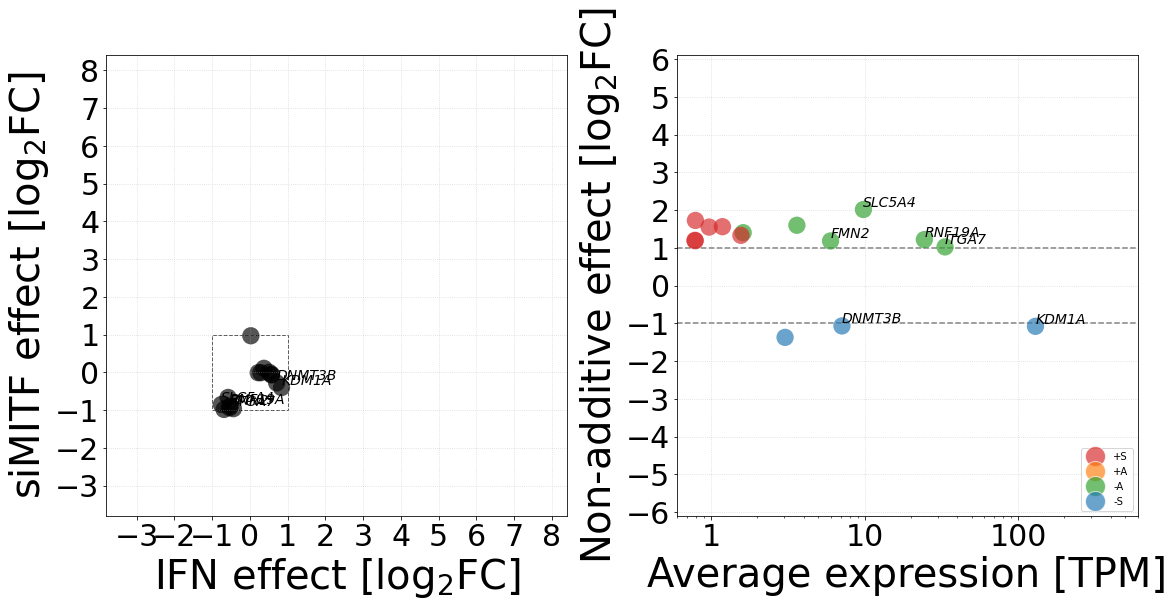

number of genes in the figure: 15

(20, 16)
1	ENSG00000000971	CFH	complement factor H 
2	ENSG00000006451	RALA	RAS like proto-oncogene A 
3	ENSG00000008517	IL32	interleukin 32 
4	ENSG00000019582	CD74	CD74 molecule 
5	ENSG00000082074	FYB1	FYN binding protein 1 
6	ENSG00000090539	CHRD	chordin 
7	ENSG00000105855	ITGB8	integrin subunit beta 8 
8	ENSG00000128965	CHAC1	ChaC glutathione specific gamma-glutamylcyclotransferase 1 
9	ENSG00000138755	CXCL9	C-X-C motif chemokine ligand 9 
10	ENSG00000147588	PMP2	peripheral myelin protein 2 
11	ENSG00000151117	TMEM86A	transmembrane protein 86A 
12	ENSG00000162654	GBP4	guanylate binding protein 4 
13	ENSG00000169245	CXCL10	C-X-C motif chemokine ligand 10 
14	ENSG00000170369	CST2	cystatin SA 
15	ENSG00000179583	CIITA	class II major histocompatibility complex transactivator 
16	ENSG00000206450	HLA-B	major histocompatibility complex
17	ENSG00000224103	HLA-DPA1	major histocompatibility complex
18	ENSG00000234487	HLA-F	major histocompatibility complex
19	

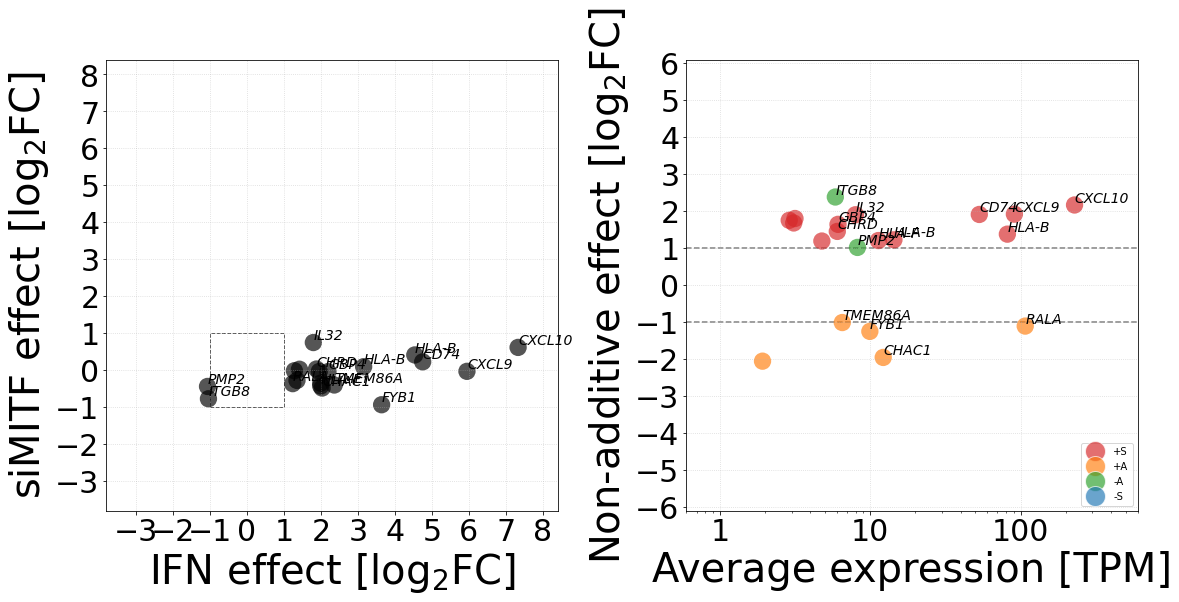

number of genes in the figure: 20

(23, 16)
1	ENSG00000004777	ARHGAP33	Rho GTPase activating protein 33 
2	ENSG00000005981	ASB4	ankyrin repeat and SOCS box containing 4 
3	ENSG00000092529	CAPN3	calpain 3 
4	ENSG00000105519	CAPS	calcyphosine 
5	ENSG00000106105	GARS1	glycyl-tRNA synthetase 1 
6	ENSG00000109819	PPARGC1A	PPARG coactivator 1 alpha 
7	ENSG00000112144	CILK1	ciliogenesis associated kinase 1 
8	ENSG00000115318	LOXL3	lysyl oxidase like 3 
9	ENSG00000122547	EEPD1	endonuclease/exonuclease/phosphatase family domain containing 1 
10	ENSG00000123200	ZC3H13	zinc finger CCCH-type containing 13 
11	ENSG00000140522	RLBP1	retinaldehyde binding protein 1 
12	ENSG00000140795	MYLK3	myosin light chain kinase 3 
13	ENSG00000143786	CNIH3	cornichon family AMPA receptor auxiliary protein 3 
14	ENSG00000144959	NCEH1	neutral cholesterol ester hydrolase 1 
15	ENSG00000145107	TM4SF19	transmembrane 4 L six family member 19 
16	ENSG00000152270	PDE3B	phosphodiesterase 3B 
17	ENSG00000155495	MAGEC1	MAGE 

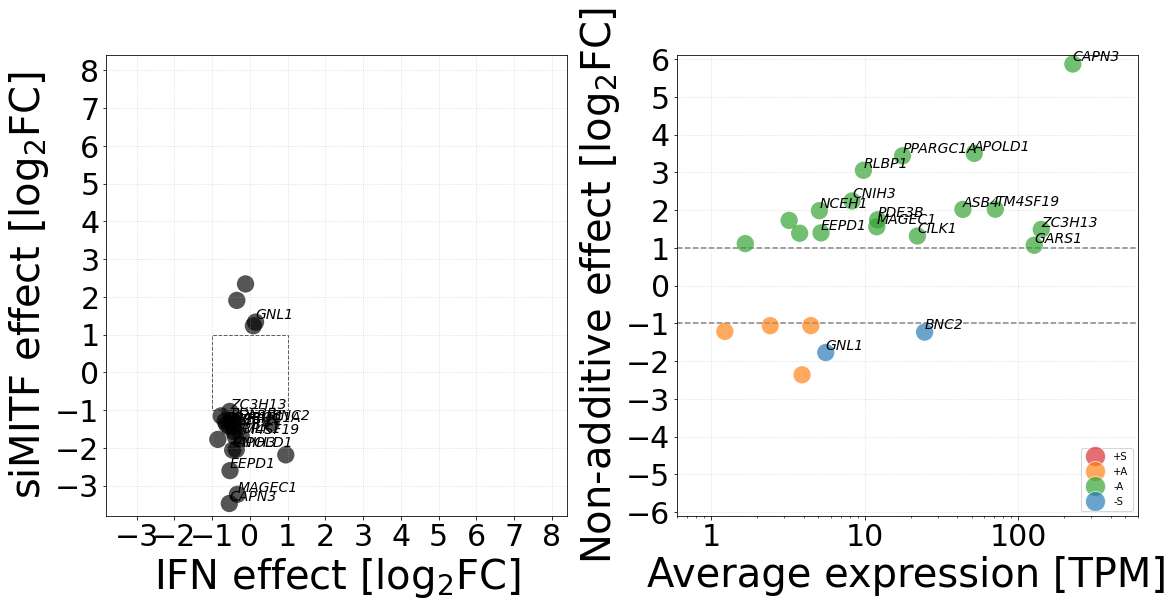

number of genes in the figure: 23

(8, 16)
1	ENSG00000041982	TNC	tenascin C 
2	ENSG00000108691	CCL2	C-C motif chemokine ligand 2 
3	ENSG00000112473	SLC39A7	solute carrier family 39 member 7 
4	ENSG00000137265	IRF4	interferon regulatory factor 4 
5	ENSG00000156219	ART3	ADP-ribosyltransferase 3 (inactive) 
6	ENSG00000175899	A2M	alpha-2-macroglobulin 
7	ENSG00000185885	IFITM1	interferon induced transmembrane protein 1 
8	ENSG00000278167	CCL18	C-C motif chemokine ligand 18 


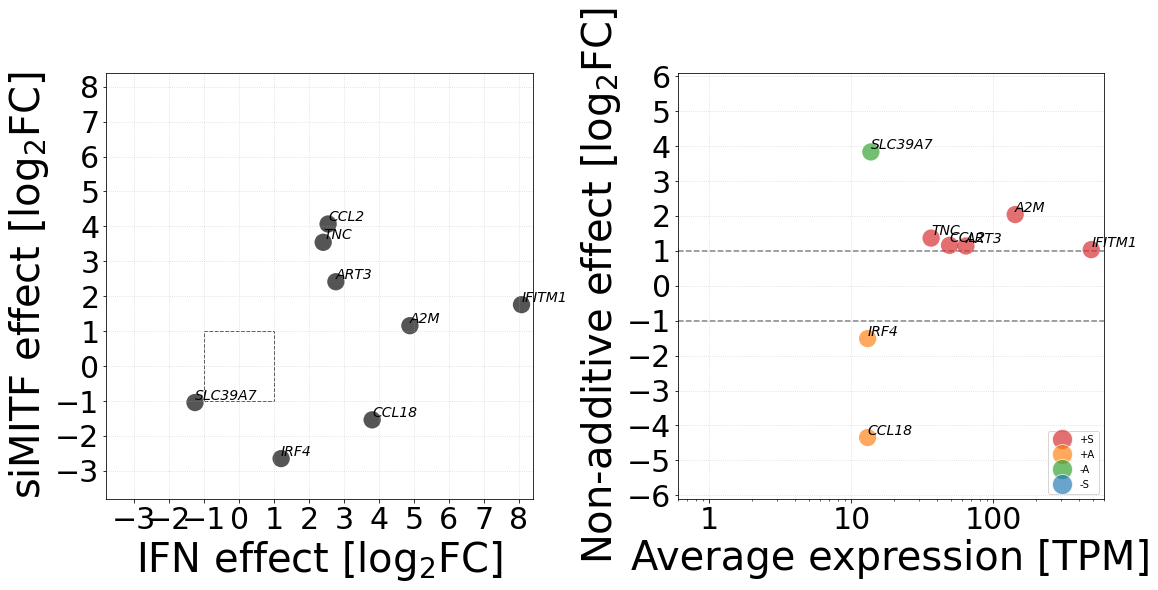

number of genes in the figure: 8



In [27]:
def figure_builder(sub, axes_lims):
    
    fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))
    
    counter = 0
    
    for ensembl, row in sub.iterrows():
        counter = counter + 1

        ### left panel
        x = sub.loc[ensembl, 'A1A0_log2fc']
        y = sub.loc[ensembl, 'B0A0_log2fc']
        
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        if sub.loc[ensembl, 'average_expression_tpm'] > 5:
            left_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')
            
        ### right panel
        x = sub.loc[ensembl, 'average_expression_tpm']
        y = sub.loc[ensembl, 'log2FC_observed_expected']

        # set the color
        if sub.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif sub.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif sub.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif sub.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'

        # plot
        right_panel.scatter(x, y, s=300, marker='o', c=the_color, alpha=2/3, edgecolor='none')

        # set the labels
        if x > 5:
            right_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')

        # print for building tables and enrichments
        #!print(ensembl)

        print('{}\t{}\t{}\t{}'.format(counter, ensembl, sub.loc[ensembl, 'geneID'], sub.loc[ensembl, 'description']))
            
    # close left panel
    left_panel.set_xlim([axes_lims[0], axes_lims[1]])
    left_panel.set_ylim([axes_lims[0], axes_lims[1]])
    left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_xlabel('IFN effect [log$_2$FC]')
    left_panel.set_ylabel('siMITF effect [log$_2$FC]')
    the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
    left_panel.add_patch(the_patch)
    left_panel.grid(alpha=0.5, ls=':')
    left_panel.set_aspect('equal', 'box')
    
    # close right panel
    right_panel.set_xscale("log")
    
    right_panel.set_xticks([1, 10, 100], ['1', '10', '100'])
    right_panel.set_yticks([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
    right_panel.set_xlim([axes_lims[2], axes_lims[3]])
    right_panel.set_ylim([axes_lims[4], axes_lims[5]])
    right_panel.set_xlabel('Average expression [TPM]')
    right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
    right_panel.axhline(numpy.log2(2), ls='--', color='black', zorder=0, alpha=1/2)
    right_panel.axhline(-numpy.log2(2), ls='--', color='black', zorder=0, alpha=1/2)
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:red', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:green', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:blue', markersize=20, alpha=2/3)
    ]
    right_panel.legend(legend_elements, ['+S', '+A', '-A', '-S'], loc=4)
    right_panel.grid(alpha=0.5, ls=':')   

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    # last print
    print('number of genes in the figure: {}'.format(counter))
    print()    
    
    return None

###
### define general limits
###

axes_lims = [-3.8, 8.4, 0.6, 600, -6.1, 6.1]

x = plotting_setA['A1A0_log2fc'].values
y = plotting_setA['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setA['average_expression_tpm'].values
y = plotting_setA['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))
print('')

## case of non-additive effects when nothing observed upon single factor
sub = plotting_setA[(numpy.abs(plotting_setA['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setA['B0A0_log2fc']) < 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

## case IFN-only effect
sub = plotting_setA[(numpy.abs(plotting_setA['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setA['B0A0_log2fc']) < 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

### case siMITF-only effect
sub = plotting_setA[(numpy.abs(plotting_setA['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setA['B0A0_log2fc']) > 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

#! case both IFN and siMITF effect
sub = plotting_setA[(numpy.abs(plotting_setA['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setA['B0A0_log2fc']) > 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

In [28]:
sub


,siCTRL_wo_IFN_tpm,siCTRL_with_IFN_tpm,siMITF_wo_IFN_tpm,siMITF_with_IFN_tpm,average_expression_tpm,max_expression_tpm,geneID,description,A1A0_log2fc,B0A0_log2fc,P_A1A0,P_B0A0,P_interaction,expected,log2FC_observed_expected,interaction_type
ENSG00000041982,1.533225,12.424779,28.558629,103.180046,36.424170,103.180046,TNC,tenascin C,2.405851,3.544532,1.530374e-66,1.539977e-237,9.331795e-06,39.450183,1.364861,+S
ENSG00000108691,1.791257,15.304826,45.827159,133.562631,49.121468,133.562631,CCL2,C-C motif chemokine ligand 2,2.546312,4.068359,1.357283e-50,2.805116e-161,4.587507e-06,59.340729,1.157074,+S
ENSG00000112473,22.474096,8.768202,10.382727,13.240690,13.716429,22.474096,SLC39A7,solute carrier family 39 member 7,-1.264905,-1.044223,8.985437e-07,2.134979e-11,2.988773e-03,0.000000,3.831947,-A
ENSG00000137265,13.131004,31.489533,1.253155,6.220183,13.023469,31.489533,IRF4,interferon regulatory factor 4,1.201111,-2.648845,4.489263e-111,1.226070e-160,3.832879e-08,19.611684,-1.513355,+A
ENSG00000156219,5.900176,46.040502,35.820787,168.527777,64.072311,168.527777,ART3,ADP-ribosyltransferase 3 (inactive),2.769198,2.415815,1.545447e-66,3.079312e-55,2.400957e-02,75.961113,1.139320,+S
ENSG00000175899,2.594963,105.467244,7.016264,454.510102,142.397143,454.510102,A2M,alpha-2-macroglobulin,4.888289,1.156953,1.469859e-316,1.448370e-44,1.260323e-03,109.888545,2.038373,+S
ENSG00000185885,1.341066,634.322677,6.923906,1311.922707,488.627589,1311.922707,IFITM1,interferon induced transmembrane protein 1,8.084180,1.759046,3.310497e-76,1.713621e-09,2.202588e-05,639.905517,1.034598,+S
ENSG00000278167,2.502833,48.068406,0.205140,1.301031,13.019353,48.068406,CCL18,C-C motif chemokine ligand 18,3.808200,-1.539322,1.574903e-281,6.803541e-17,4.667044e-03,45.770712,-4.345253,+A


## 10.3. set C

-1.2649046307834761 8.084180132075929
-3.4741285602944663 4.0683585030904075
0.7850361479241078 2268.4382864560025
-4.345253020438813 5.867488277016092

(53, 16)
(53, 16)
(53, 16)
1	ENSG00000004487	KDM1A	lysine demethylase 1A 
2	ENSG00000011114	BTBD7	BTB domain containing 7 
3	ENSG00000026950	BTN3A1	butyrophilin subfamily 3 member A1 
4	ENSG00000034677	RNF19A	ring finger protein 19A
5	ENSG00000075340	ADD2	adducin 2 
6	ENSG00000088305	DNMT3B	DNA methyltransferase 3 beta 
7	ENSG00000095383	TBC1D2	TBC1 domain family member 2 
8	ENSG00000099194	SCD	stearoyl-CoA desaturase 
9	ENSG00000100162	CENPM	centromere protein M 
10	ENSG00000100191	SLC5A4	solute carrier family 5 member 4 
11	ENSG00000103978	TMEM87A	transmembrane protein 87A 
12	ENSG00000104313	EYA1	EYA transcriptional coactivator and phosphatase 1 
13	ENSG00000104983	CCDC61	coiled-coil domain containing 61 
14	ENSG00000105679	GAPDHS	glyceraldehyde-3-phosphate dehydrogenase
15	ENSG00000109861	CTSC	cathepsin C 
16	ENSG00000119397	CNTRL	

<ipython-input-29-45959f96c643>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.drop_duplicates(inplace=True)


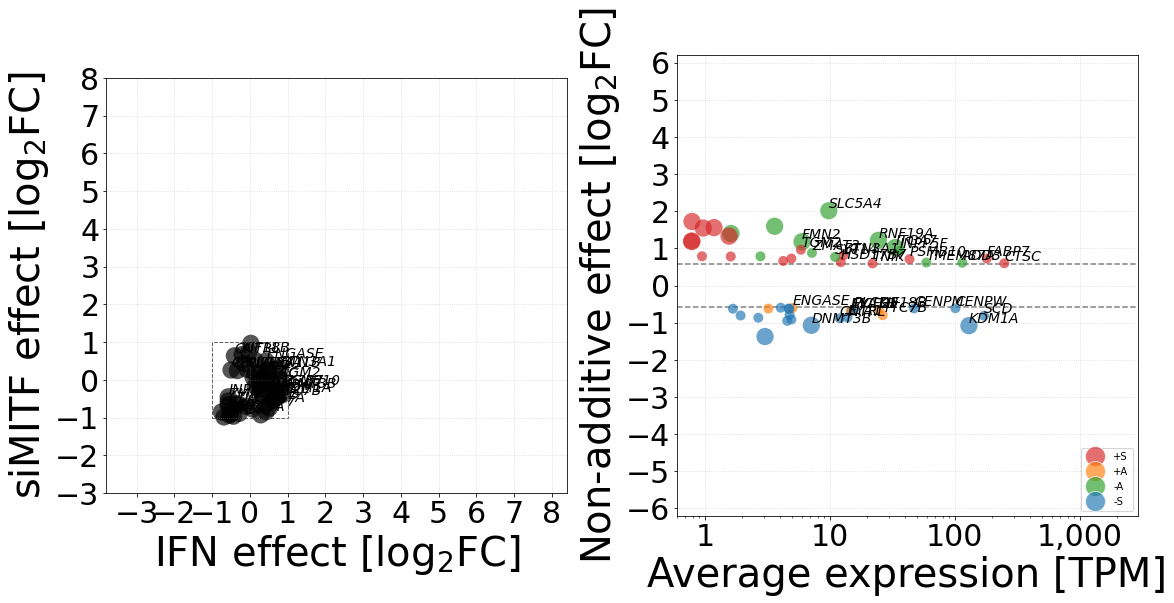

number of genes in the figure: 53

/home/adrian/projects/nautholsvik/results/non-additive/ENSG00000242574
(39, 16)
(39, 16)
(39, 16)
1	ENSG00000000971	CFH	complement factor H 
2	ENSG00000001617	SEMA3F	semaphorin 3F 
3	ENSG00000004799	PDK4	pyruvate dehydrogenase kinase 4 
4	ENSG00000006451	RALA	RAS like proto-oncogene A 
5	ENSG00000008517	IL32	interleukin 32 
6	ENSG00000019582	CD74	CD74 molecule 
7	ENSG00000075826	SEC31B	SEC31 homolog B
8	ENSG00000082074	FYB1	FYN binding protein 1 
9	ENSG00000090539	CHRD	chordin 
10	ENSG00000105855	ITGB8	integrin subunit beta 8 
11	ENSG00000114279	FGF12	fibroblast growth factor 12 
12	ENSG00000115935	WIPF1	WAS/WASL interacting protein family member 1 
13	ENSG00000120217	CD274	CD274 molecule 
14	ENSG00000125347	IRF1	interferon regulatory factor 1 
15	ENSG00000128965	CHAC1	ChaC glutathione specific gamma-glutamylcyclotransferase 1 
16	ENSG00000132530	XAF1	XIAP associated factor 1 
17	ENSG00000138755	CXCL9	C-X-C motif chemokine ligand 9 
18	ENSG00000139625

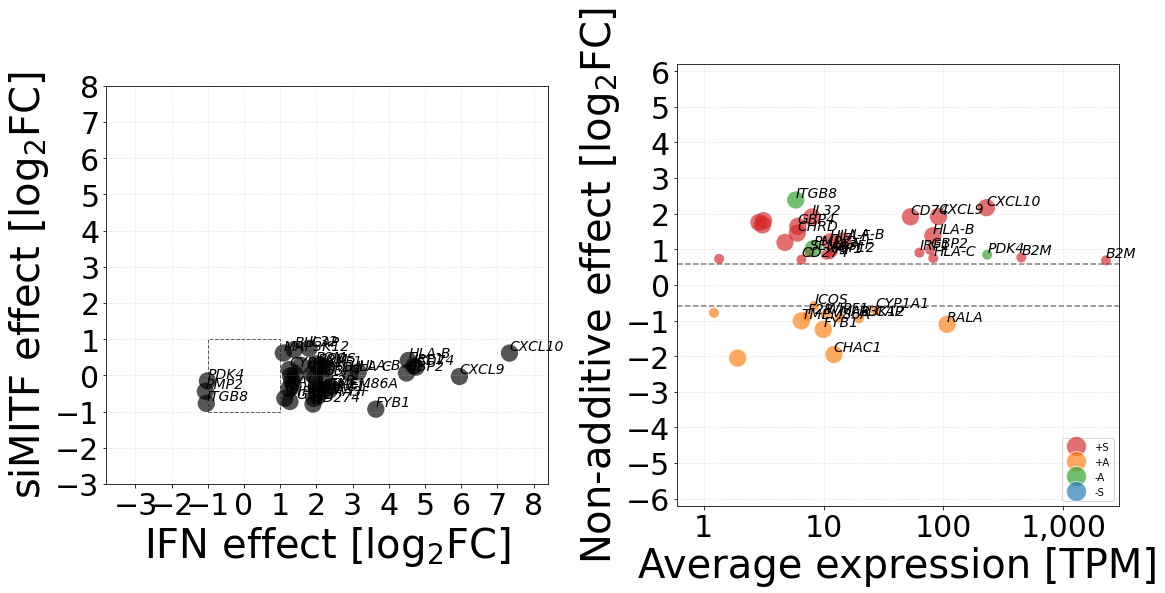

number of genes in the figure: 39

/home/adrian/projects/nautholsvik/results/non-additive/ENSG00000283537
(49, 16)
(49, 16)
(49, 16)
1	ENSG00000004777	ARHGAP33	Rho GTPase activating protein 33 
2	ENSG00000004846	ABCB5	ATP binding cassette subfamily B member 5 
3	ENSG00000005981	ASB4	ankyrin repeat and SOCS box containing 4 
4	ENSG00000065371	ROPN1	rhophilin associated tail protein 1 
5	ENSG00000077585	GPR137B	G protein-coupled receptor 137B 
6	ENSG00000082196	C1QTNF3	C1q and TNF related 3 
7	ENSG00000092529	CAPN3	calpain 3 
8	ENSG00000100167	SEPTIN3	septin 3 
9	ENSG00000104765	BNIP3L	BCL2 interacting protein 3 like 
10	ENSG00000105519	CAPS	calcyphosine 
11	ENSG00000106105	GARS1	glycyl-tRNA synthetase 1 
12	ENSG00000109819	PPARGC1A	PPARG coactivator 1 alpha 
13	ENSG00000112144	CILK1	ciliogenesis associated kinase 1 
14	ENSG00000115318	LOXL3	lysyl oxidase like 3 
15	ENSG00000119403	PHF19	PHD finger protein 19 
16	ENSG00000122547	EEPD1	endonuclease/exonuclease/phosphatase family domain co

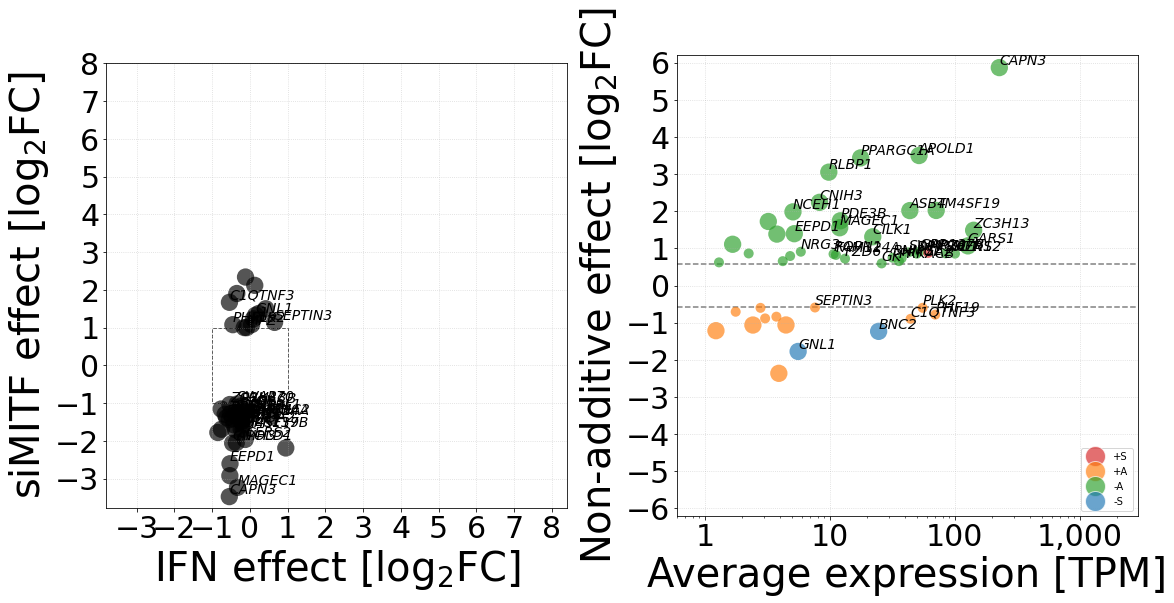

number of genes in the figure: 49

/home/adrian/projects/nautholsvik/results/non-additive/ENSG00000284610
(11, 16)
(11, 16)
(11, 16)
1	ENSG00000041982	TNC	tenascin C 
2	ENSG00000102524	TNFSF13B	TNF superfamily member 13b 
3	ENSG00000108691	CCL2	C-C motif chemokine ligand 2 
4	ENSG00000112473	SLC39A7	solute carrier family 39 member 7 
5	ENSG00000137265	IRF4	interferon regulatory factor 4 
6	ENSG00000156219	ART3	ADP-ribosyltransferase 3 (inactive) 
7	ENSG00000168306	ACOX2	acyl-CoA oxidase 2 
8	ENSG00000175899	A2M	alpha-2-macroglobulin 
9	ENSG00000185338	SOCS1	suppressor of cytokine signaling 1 
10	ENSG00000185885	IFITM1	interferon induced transmembrane protein 1 
11	ENSG00000278167	CCL18	C-C motif chemokine ligand 18 


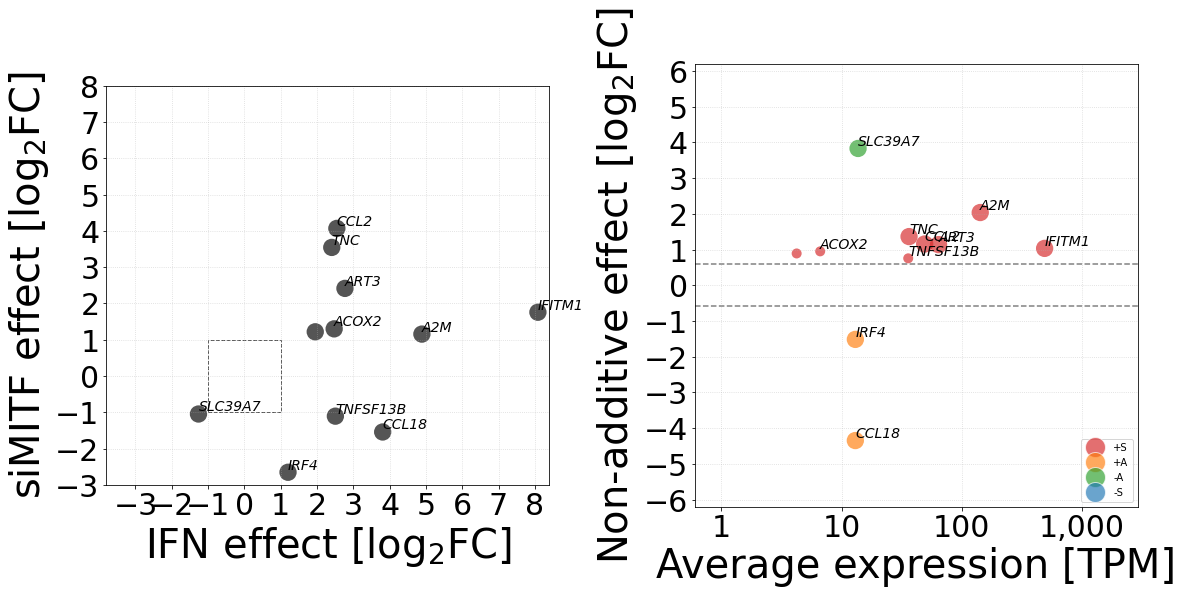

number of genes in the figure: 11

/home/adrian/projects/nautholsvik/results/non-additive/ENSG00000278167


In [29]:
def figure_builder(sub, axes_lims):
    
    print(sub.shape)
    sub.drop_duplicates(inplace=True)
    print(sub.shape)
    
    fig, (left_panel, right_panel) = matplotlib.pyplot.subplots(1, 2, figsize=(16, 9), subplot_kw=dict(box_aspect=1))
    
    counter = 0
    
    for ensembl, row in sub.iterrows():
        counter = counter + 1

        ### left panel
        x = sub.loc[ensembl, 'A1A0_log2fc']
        y = sub.loc[ensembl, 'B0A0_log2fc']
        
        left_panel.scatter(x, y, s=300, c='black', alpha=2/3, edgecolor='none')
        if sub.loc[ensembl, 'average_expression_tpm'] > 5:
            left_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')
            
        ### right panel
        x = sub.loc[ensembl, 'average_expression_tpm']
        y = sub.loc[ensembl, 'log2FC_observed_expected']

        # set the color
        if sub.loc[ensembl, 'interaction_type'] == '+S':
            the_color = 'tab:red'
        elif sub.loc[ensembl, 'interaction_type'] == '+A':
            the_color = 'tab:orange'
        elif sub.loc[ensembl, 'interaction_type'] == '-A':
            the_color = 'tab:green'
        elif sub.loc[ensembl, 'interaction_type'] == '-S':
            the_color = 'tab:blue'
        else:
            the_color = 'black'
            
        ### define the size
        if numpy.abs(y) > 1:
            the_size = 300
        else:
            the_size = 100

        # plot
        right_panel.scatter(x, y, s=the_size, marker='o', c=the_color, alpha=2/3, edgecolor='none')

        # set the labels
        if x > 5:
            right_panel.text(x, y, sub.loc[ensembl, 'geneID'], horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontstyle='italic')

        # print for building tables and enrichments
        print('{}\t{}\t{}\t{}'.format(counter, ensembl, sub.loc[ensembl, 'geneID'], sub.loc[ensembl, 'description']))
            
    # close left panel
    left_panel.set_xlim([axes_lims[0], axes_lims[1]])
    left_panel.set_xlim([axes_lims[0], axes_lims[1]])
    left_panel.set_xticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_yticks([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])
    left_panel.set_xlabel('IFN effect [log$_2$FC]')
    left_panel.set_ylabel('siMITF effect [log$_2$FC]')
    the_patch = matplotlib.patches.Rectangle((-1,-1), 2, 2, edgecolor='black', facecolor='none', ls='--', alpha=2/3)
    left_panel.add_patch(the_patch)
    left_panel.grid(alpha=0.5, ls=':')
    left_panel.set_aspect('equal', 'box')
    
    # close right panel
    right_panel.set_xscale("log")
    right_panel.set_xticks([1, 10, 100, 1000], ['1', '10', '100', '1,000'])
    right_panel.set_yticks([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
    right_panel.set_xlim([axes_lims[2], axes_lims[3]])
    right_panel.set_ylim([axes_lims[4], axes_lims[5]])
    right_panel.set_xlabel('Average expression [TPM]')
    right_panel.set_ylabel('Non-additive effect [log$_2$FC]')
    right_panel.axhline(numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
    right_panel.axhline(-numpy.log2(1.5), ls='--', color='black', zorder=0, alpha=1/2)
    legend_elements = [
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:red', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:orange', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:green', markersize=20, alpha=2/3),
        matplotlib.lines.Line2D([0], [0], marker='o', color='white', markerfacecolor='tab:blue', markersize=20, alpha=2/3)
    ]
    right_panel.legend(legend_elements, ['+S', '+A', '-A', '-S'], loc=4)
    right_panel.grid(alpha=0.5, ls=':')   

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    # last print
    print('number of genes in the figure: {}'.format(counter))
    print()
    
    # plot gene-specific trend
    figure_file = expression_figures_dir + ensembl
    print(figure_file)
    
    return None

###
### define general limits
###

axes_lims = [-3.8, 8.4, 0.6, 2900, -6.2, 6.2]

x = plotting_setC['A1A0_log2fc'].values
y = plotting_setC['B0A0_log2fc'].values
print(min(x), max(x))
print(min(y), max(y))

x = plotting_setC['average_expression_tpm'].values
y = plotting_setC['log2FC_observed_expected'].values
print(min(x), max(x))
print(min(y), max(y))
print('')

## case of non-additive effects when nothing observed upon single factor
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) < 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

## case IFN-only effect
#! plenty of immune functions here. Fascinating hits
#! worth reading: https://pubmed.ncbi.nlm.nih.gov/26530832/
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) < 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

### case siMITF-only effect
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) < 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) > 1)]
print(sub.shape)
figure_builder(sub, axes_lims)

#! case both IFN and siMITF effect
sub = plotting_setC[(numpy.abs(plotting_setC['A1A0_log2fc']) > 1) & (numpy.abs(plotting_setC['B0A0_log2fc']) > 1)]
print(sub.shape)
figure_builder(sub, axes_lims)